In [ ]:
# %% Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd

# Set GPU device
print(torch.cuda.is_available())
device = torch.device("cuda:0")

True


In [ ]:
# Download dataset from Google Drive
! gdown --id 1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km

# Links

# Zero Pad 128: 1-9hnSKSnqQmELI5_PAPy9BhLDc-bKEbE

# White Pad 128: 1ZdK5f5rbR4E7rzzAIXm84L8Mjp9HCfS0

# Zero Pad 224: 1-9sy-KxqUqBsW-GcsvfThzQL-0QiMfBS

# White Pad 224: 1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km

# Zero Pad 512: 1-DYICH8IyqrQh--WprRTrpYDzS-QgUc0

# White Pad 512: 1-AmotnWWdvKNxYlkGCS4BkrLY1BnrnaU

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km
From (redirected): https://drive.google.com/uc?id=1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km&confirm=t&uuid=3e21e684-d627-499f-a616-21c5c296110d
To: /content/White_Pad_224.zip
100% 608M/608M [00:15<00:00, 38.6MB/s]


In [ ]:
! mkdir data
!unzip White_Pad_224.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/white_pad_224/1_Sclerotic/S-1909-007195_PAS_2of2_647582c3435c92704a444147.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2006-001849_PAS_1of2_64542f6e435c92704a3575ff.png  
  inflating: content/white_pad_224/1_Sclerotic/S-1910-000090_PAS_1of2_64551d4e435c92704a3d0f4c.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2102-006457_PAS_2of2_645527ff435c92704a3ef449.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2010-013043_PAS_1of2_64552795435c92704a3e03c2.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2006-003978_PAS_2of2_645432e3435c92704a38b27a.png  
  inflating: content/white_pad_224/1_Sclerotic/S-1908-009734_PAS_2of2_64551cdf435c92704a3c452b.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2102-006457_PAS_2of2_645527ff435c92704a3ef441.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2103-004716_PAS_2of2_64552857435c92704a3faeb0.png  
  inflating: content/white_pad_224/1_Scl

In [ ]:
! mv content/* data

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/data/white_pad_224', output="output", seed=1345, ratio=(0.8, 0.1,0.1))

Copying files: 5758 files [00:02, 2614.28 files/s]


In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
TRAIN_ROOT = '/content/output/train'
VAL_ROOT = '/content/output/val'
TEST_ROOT = '/content/output/test'
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)
val_dataset = torchvision.datasets.ImageFolder(root=VAL_ROOT)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_ROOT)

In [ ]:
# %% Building the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        for param in self.vgg16.parameters():
          param.requires_grad = False

        # Replace output layer according to our problem
        in_feats = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(in_feats, 2)

    def forward(self, x):
        x = self.vgg16(x)
        return x

model = CNNModel()
model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNModel(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [ ]:
# %% Prepare data for pretrained model
train_dataset = torchvision.datasets.ImageFolder(
        root=TRAIN_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor()
        ])
)

test_dataset = torchvision.datasets.ImageFolder(
        root=TEST_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor()
        ])
)

val_dataset = torchvision.datasets.ImageFolder(
        root=VAL_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor()
        ])
)

#train_dataset[0][0].permute(1,2,0)


In [ ]:
# %% Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
# %% Train
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


epochs = 30

# initialize losses
trainLoss = torch.zeros(epochs)
devLoss   = torch.zeros(epochs)
trainAcc  = torch.zeros(epochs)
devAcc    = torch.zeros(epochs)


# Iterate x epochs over the train data
for epoch in range(epochs):
    print(f'Epoch {epoch}')
    model.train()
    batchLoss = []
    batchAcc  = []

    for i, batch in enumerate(train_loader, 0):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Labels are automatically one-hot-encoded
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        print(loss.item())

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(outputs,axis=1) == labels).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epoch] = np.mean(batchLoss)
    trainAcc[epoch]  = 100*np.mean(batchAcc)

    #### test performance
    model.eval() # switch to test mode
    X,y = next(iter(val_loader))

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = model(X)
      loss = cross_entropy_loss(yHat,y)

    # and get average losses and accuracies across the batches
    devLoss[epoch] = loss.item()
    devAcc[epoch]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

  # end epochs


Epoch 0
0.494150310754776
0.6778745055198669
0.5395107865333557
0.5701778531074524
0.5254902839660645
0.5088562369346619
0.6100327372550964
0.5530324578285217
0.595750629901886
0.5232187509536743
0.4236191511154175
0.45551618933677673
0.552490234375
0.4077621102333069
0.47515496611595154
0.4994719624519348
0.46494245529174805
0.5450411438941956
0.5278738141059875
0.5251743197441101
0.5367686748504639
0.42137086391448975
0.5381401181221008
0.5214946866035461
0.49359291791915894
0.5323445796966553
0.5753705501556396
0.597411036491394
0.45763909816741943
0.499944269657135
0.39668360352516174
0.6129976511001587
0.483232706785202
0.6543972492218018
0.5382063388824463
0.41395285725593567
0.5244219899177551
0.46443551778793335
0.5433341264724731
0.46105241775512695
0.5560676455497742
0.4933815896511078
0.4248489439487457
0.5035451650619507
0.5657809972763062
0.5076143741607666
0.4178224503993988
0.40326032042503357
0.3882672190666199
0.46727871894836426
0.6004185080528259
0.5656123757362366
0

In [ ]:
test_data_loader = iter(test_loader)
count = 0
testAcc = 0

for i in range(1000000):
  # %% Inspect predictions for first batch
  import pandas as pd
  try:
    inputs, labels = next(test_data_loader)
    inputs = inputs.to(device)
    labels = labels.numpy()

    model.eval()
    with torch.no_grad():
      outputs = model(inputs).max(1).indices.detach().cpu().numpy()
      comparison = pd.DataFrame()
      print("Batch accuracy: ", (labels==outputs).sum()/len(labels))
      testAcc += (labels==outputs).sum()/len(labels)
      count += 1
      comparison["labels"] = labels

      comparison["outputs"] = outputs
      print(comparison)
  except StopIteration:
    break

testAcc = (testAcc/count) * 100

Batch accuracy:  0.90625
    labels  outputs
0        0        0
1        0        0
2        1        1
3        0        0
4        0        0
5        0        0
6        0        0
7        0        0
8        0        0
9        0        0
10       0        0
11       0        0
12       0        0
13       1        0
14       0        0
15       1        0
16       0        0
17       0        0
18       0        0
19       0        1
20       0        0
21       0        0
22       0        0
23       0        0
24       0        0
25       0        0
26       0        0
27       0        0
28       0        0
29       0        0
30       0        0
31       0        0
Batch accuracy:  0.90625
    labels  outputs
0        0        0
1        0        0
2        0        0
3        0        0
4        0        0
5        1        0
6        0        0
7        0        0
8        0        0
9        0        0
10       0        0
11       0        0
12       0        0
13       1

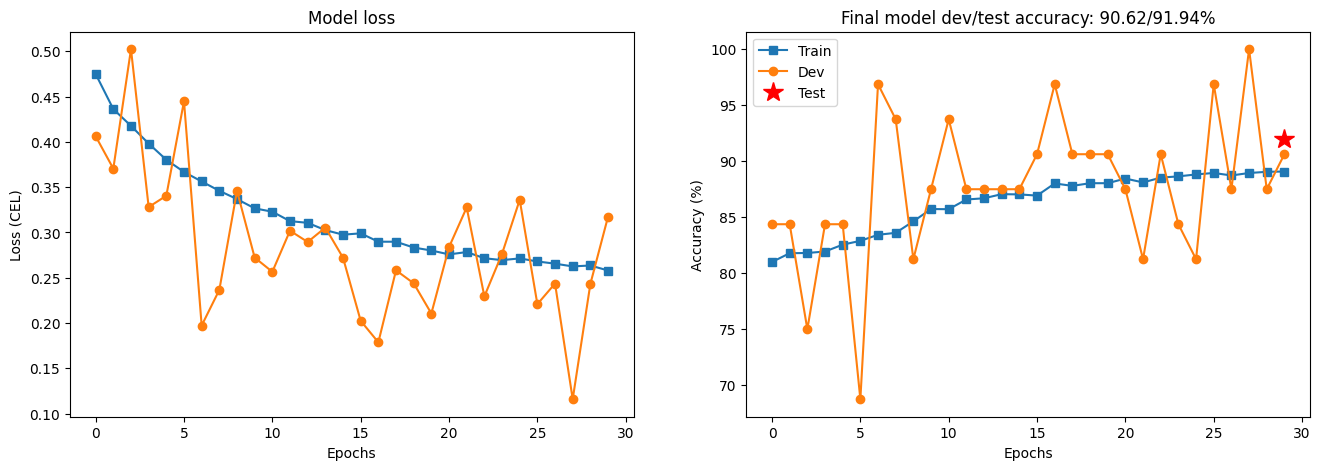

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
#ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()